In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

## install libs

In [ ]:
pip install torch torchaudio librosa

## imports

In [2]:
import os
import math
import matplotlib.pyplot as plt

import torch
import torch.nn as nn

import torchaudio
import torchaudio.transforms as transforms
from torch.utils.data import Dataset, DataLoader

## set randomness seed for reproducibility

In [3]:
torch.manual_seed(121)

## define dataset object

In [4]:
class AudioDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.classes = ['real', 'fake']
        self.data = []
        for label in self.classes:
            class_dir = os.path.join(root_dir, label)
            for file_name in os.listdir(class_dir):
                if file_name.endswith(".wav"):
                    file_path = os.path.join(class_dir, file_name)
                    self.data.append((file_path, label))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        file_path, label = self.data[idx]
        waveform, sample_rate = torchaudio.load(file_path)
        if self.transform:
            spectrogram = self.transform(waveform)
            spectrogram = spectrogram.squeeze(0)  # Remove channel if it's 1
        label = self.classes.index(label)
        return spectrogram.transpose(0, 1), label  # Transpose to [time, features]

## define model (transformer) architecture

In [5]:
class AudioTransformer(nn.Module):
    def __init__(self, n_mels=64, n_classes=2, nhead=8, num_encoder_layers=3, dim_feedforward=256, dropout=0.1):
        super(AudioTransformer, self).__init__()
        
        self.n_mels = n_mels
        self.positional_encoding = nn.Parameter(self.create_positional_encoding(10000, n_mels), requires_grad=False)
        
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=n_mels, 
            nhead=nhead, 
            dim_feedforward=dim_feedforward, 
            dropout=dropout
        )
        
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_encoder_layers)
        
        self.fc = nn.Linear(n_mels, n_classes)

    def create_positional_encoding(self, length, dim):
        pe = torch.zeros(length, dim)
        position = torch.arange(0, length, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, dim, 2).float() * (-math.log(10000.0) / dim))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        return pe.unsqueeze(0)

    def forward(self, x):
        # Dynamically resize positional encoding to match input length
        seq_length = x.size(1)
        x = x + self.positional_encoding[:, :seq_length, :].to(x.device)
        
        # Pass through the transformer encoder
        x = self.transformer_encoder(x)
        
        # Global average pooling
        x = x.mean(dim=1)
        
        # Classification layer
        x = self.fc(x)
        
        return x

## load and transform datasets (train, validation, and test sets)

In [6]:
transform = transforms.MelSpectrogram(sample_rate=16000, n_mels=64)

train_dataset = AudioDataset(root_dir='/Users/Ashish.Jha/Downloads/for-2seconds/training/', transform=transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

val_dataset = AudioDataset(root_dir='/Users/Ashish.Jha/Downloads/for-2seconds/validation/', transform=transform)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

test_dataset = AudioDataset(root_dir='/Users/Ashish.Jha/Downloads/for-2seconds/testing', transform=transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

## visualize data samples

In [7]:
d = test_dataset[-10]

In [8]:
d

(tensor([[2.1805e-01, 3.4350e-01, 6.6891e-01,  ..., 1.1997e-04, 1.2618e-04,
          4.7308e-05],
         [1.6098e-01, 1.8481e-01, 2.3813e-01,  ..., 4.3364e-04, 4.4256e-04,
          2.1390e-04],
         [2.6825e-02, 7.2369e-02, 1.9422e-01,  ..., 1.0392e-01, 8.6961e-02,
          1.0592e-02],
         ...,
         [4.6187e-01, 1.9791e+00, 6.0691e+00,  ..., 1.1090e-02, 6.2001e-03,
          3.5782e-03],
         [2.4654e-01, 8.6965e+00, 3.1640e+01,  ..., 3.4925e-04, 2.1003e-04,
          1.6148e-04],
         [2.7974e+01, 5.0236e+01, 1.0874e+02,  ..., 3.1445e-04, 1.8837e-04,
          1.3856e-04]]),
 1)

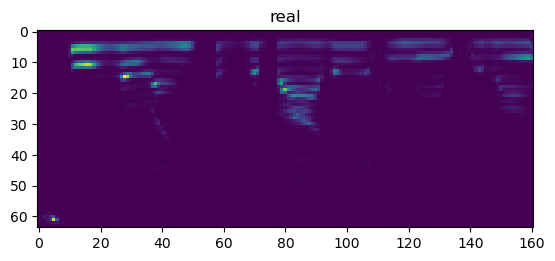

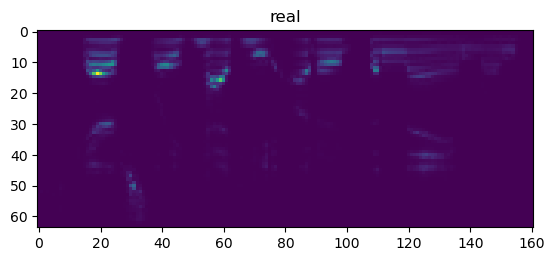

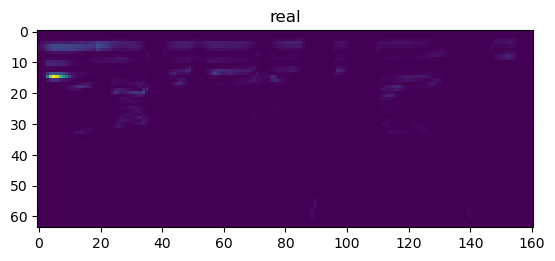

In [9]:
for i in range(1, 4):
    plt.figure()
    plt.imshow(test_dataset[i][0].T);
    plt.title({0: "real", 1: "fake"}.get(test_dataset[i][1]))

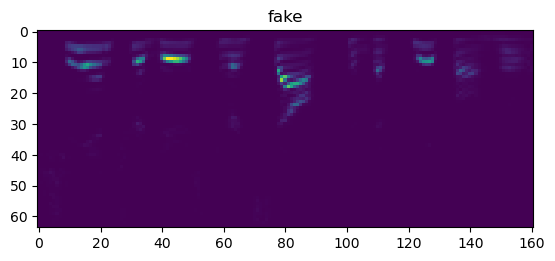

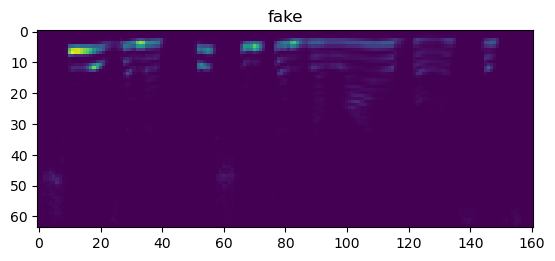

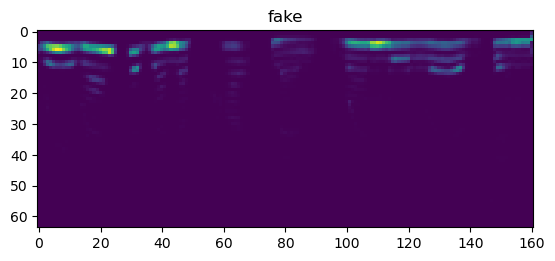

In [10]:
for i in range(1, 4):
    plt.figure()
    plt.imshow(test_dataset[-i][0].T);
    plt.title({0: "real", 1: "fake"}.get(test_dataset[-i][1]))

## instantiate and train model

In [11]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = AudioTransformer(n_mels=64, n_classes=2).to(device)
criterion = nn.CrossEntropyLoss(weight=torch.tensor([1, 1], dtype=torch.float).to(device))
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

num_epochs = 15
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for i, (inputs, labels) in enumerate(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader)}")

    # Validation phase
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    print(f'Validation Accuracy: {100 * correct / total} %')

/Users/Ashish.Jha/anaconda3/lib/python3.11/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch 1/15, Loss: 0.4445279352452171
Validation Accuracy: 68.0820948336872 %
Epoch 2/15, Loss: 0.35368777953037134
Validation Accuracy: 68.22363765038924 %
Epoch 3/15, Loss: 0.3215806980529966
Validation Accuracy: 75.08846426043878 %
Epoch 4/15, Loss: 0.30280909099076925
Validation Accuracy: 72.1868365180467 %
Epoch 5/15, Loss: 0.28121886085250014
Validation Accuracy: 74.62845010615712 %
Epoch 6/15, Loss: 0.2655187372962179
Validation Accuracy: 77.95470629865534 %
Epoch 7/15, Loss: 0.2530705883621624
Validation Accuracy: 71.0544939844303 %
Epoch 8/15, Loss: 0.24132563146491892
Validation Accuracy: 77.49469214437367 %
Epoch 9/15, Loss: 0.22901932624098364
Validation Accuracy: 80.5732484076433 %
Epoch 10/15, Loss: 0.21297824616358538
Validation Accuracy: 76.53927813163482 %
Epoch 11/15, Loss: 0.21986426362763553
Validation Accuracy: 73.38995046001415 %
Epoch 12/15, Loss: 0.207100466652443
Validation Accuracy: 79.19320594479831 %
Epoch 13/15, Loss: 0.20874379732106862
Validation Accuracy:

## test trained model

In [12]:
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Test Accuracy: {100 * correct / total} %')

Test Accuracy: 59.283088235294116 %


## save trained model

In [13]:
torch.save(model.state_dict(), 'audio_classification_model.pth')

In [14]:
# import torch

# # Assuming your model class is AudioClassifier and it's already defined as above
# model = AudioClassifier()
# model.fc1 = None
# model.load_state_dict(torch.load('audio_classification_model.pth'))  # Load the trained model weights
# model.eval()  # Set the model to evaluation mode

# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# model.to(device)

## run prediction on unseen data (genuine audio sample)

In [15]:
def preprocess_audio(file_path):
    waveform, sample_rate = torchaudio.load(file_path)
    
    # Convert to mono if the audio has multiple channels
    if waveform.shape[0] > 1:
        waveform = torch.mean(waveform, dim=0, keepdim=True)
    
    # Resample if necessary
    if sample_rate != 16000:
        transform = torchaudio.transforms.Resample(orig_freq=sample_rate, new_freq=16000)
        waveform = transform(waveform)
    
    # Convert to Mel Spectrogram
    mel_spectrogram = transforms.MelSpectrogram(sample_rate=16000, n_mels=64)(waveform)
    
    mel_spectrogram = mel_spectrogram.squeeze().transpose(0, 1).unsqueeze(0)  # Ensure shape [1, time, features]
    return mel_spectrogram.to(device)

new_audio_file = '/Users/Ashish.Jha/Downloads/margot-original.wav'
input_tensor = preprocess_audio(new_audio_file)

with torch.no_grad():
    output = model(input_tensor[:, :161, :])
    _, predicted = torch.max(output, 1)

classes = ['real', 'fake']
predicted_label = classes[predicted.item()]

print(f"The model predicts the audio is: {predicted_label}")

The model predicts the audio is: real


In [16]:
input_tensor.shape

torch.Size([1, 6359, 64])

/var/folders/bc/4d78jrn15m924n8pt76chnf40000gr/T/ipykernel_3137/3247065019.py:2: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3701.)
  plt.imshow(input_tensor[:, 6080:6240, :].T);


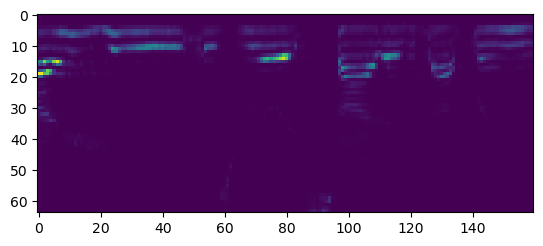

In [17]:
plt.figure()
plt.imshow(input_tensor[:, 6080:6240, :].T);

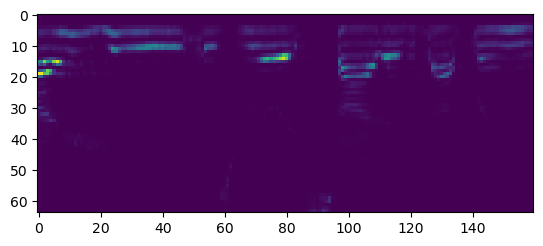

In [18]:
plt.figure()
plt.imshow(input_tensor[:, 6080:6240, :].T);

## output raw model predictions

In [19]:
output

tensor([[ 1.8318, -1.2349]])

In [20]:
input_tensor.shape

torch.Size([1, 6359, 64])

In [21]:
inputs.shape

torch.Size([32, 161, 64])

## try an unseen fake audio sample

In [22]:
new_audio_file = '/Users/Ashish.Jha/Downloads/margot-to-trump.wav'
input_tensor = preprocess_audio(new_audio_file)
with torch.no_grad():
    output = model(input_tensor[:, 160*38:160*39, :])
    _, predicted = torch.max(output, 1)

classes = ['real', 'fake']
predicted_label = classes[predicted.item()]

print(f"The model predicts the audio is: {predicted_label}")

The model predicts the audio is: fake


In [23]:
new_audio_file = '/Users/Ashish.Jha/Downloads/margot-to-trump.wav'
input_tensor = preprocess_audio(new_audio_file)
for i in range(len(input_tensor[0])//160):
    print(i*160, (i+1)*160)
    with torch.no_grad():
        output = model(input_tensor[:, i*160:(i+1)*160, :])
        _, predicted = torch.max(output, 1)

    classes = ['real', 'fake']
    predicted_label = classes[predicted.item()]

    print(f"The model predicts the audio is: {predicted_label}")

0 160
The model predicts the audio is: real
160 320
The model predicts the audio is: real
320 480
The model predicts the audio is: real
480 640
The model predicts the audio is: real
640 800
The model predicts the audio is: real
800 960
The model predicts the audio is: real
960 1120
The model predicts the audio is: real
1120 1280
The model predicts the audio is: fake
1280 1440
The model predicts the audio is: real
1440 1600
The model predicts the audio is: real
1600 1760
The model predicts the audio is: real
1760 1920
The model predicts the audio is: fake
1920 2080
The model predicts the audio is: real
2080 2240
The model predicts the audio is: real
2240 2400
The model predicts the audio is: real
2400 2560
The model predicts the audio is: fake
2560 2720
The model predicts the audio is: fake
2720 2880
The model predicts the audio is: real
2880 3040
The model predicts the audio is: real
3040 3200
The model predicts the audio is: real
3200 3360
The model predicts the audio is: real
3360 35

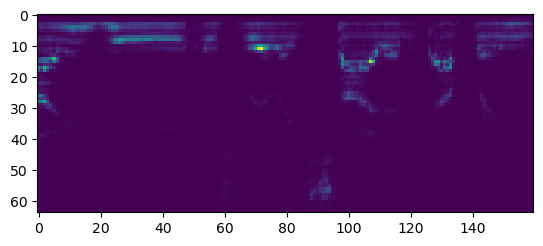

In [24]:
plt.figure()
plt.imshow(input_tensor[:,6080:6240,:].T);

In [25]:
import captum
from captum.attr import IntegratedGradients

In [26]:
ig = IntegratedGradients(model)

In [27]:
target_class = 0

In [28]:
attributions, delta = ig.attribute(input_tensor[:,6080:6240,:], target=target_class, return_convergence_delta=True)

In [29]:
attributions_normalized = (attributions - attributions.min()) / (attributions.max() - attributions.min())

In [30]:
(input_tensor[:,6080:6240,:].T * attributions_normalized.T).shape

torch.Size([64, 160, 1])

In [31]:
input_tensor[:,6080:6240].max()

tensor(59.6822)

In [32]:
input_image = (input_tensor[:,6080:6240,:] - input_tensor[:,6080:6240,:].min()) / (input_tensor[:,6080:6240,:].max() - input_tensor[:,6080:6240,:].min())

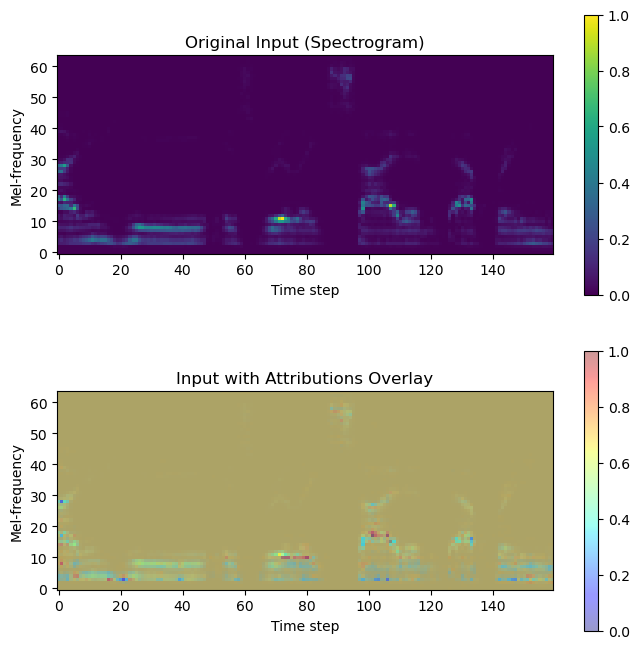

In [33]:

plt.figure(figsize=(8,8))# Show original input (spectrogram or image)
plt.subplot(2, 1, 1)
plt.imshow(input_image.T, origin='lower', cmap='viridis')
plt.title("Original Input (Spectrogram)")
plt.xlabel("Time step")
plt.ylabel("Mel-frequency")
plt.colorbar();

# Overlay attributions as heatmap on top of the input
plt.subplot(2, 1, 2)
plt.imshow(input_image.T, origin='lower', cmap='viridis', alpha=0.6)  # Original input
plt.imshow(attributions_normalized.T, origin='lower', cmap='jet', alpha=0.4)  # Attributions
plt.title("Input with Attributions Overlay")
plt.xlabel("Time step")
plt.ylabel("Mel-frequency")
plt.colorbar();

In [34]:
attributions, delta = ig.attribute(input_tensor, target=0, return_convergence_delta=True)
attr_max = attributions.squeeze(0).mean(dim=1).cpu().detach().numpy()

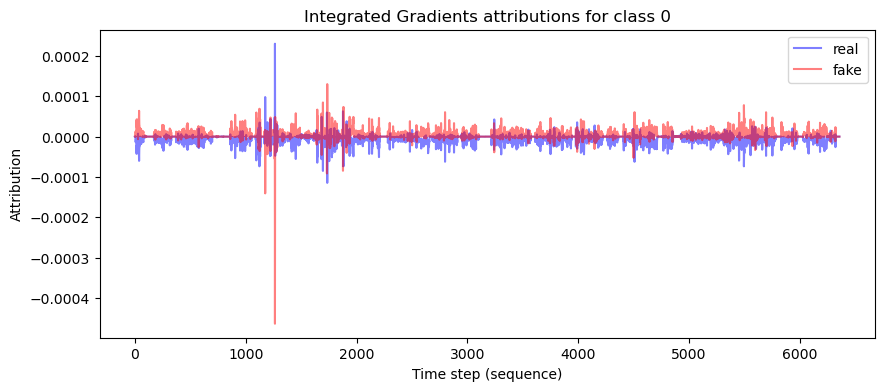

In [35]:
# Plot attributions over time
plt.figure(figsize=(10, 4))
plt.plot(attr_max, color="b", label="real", alpha=0.5)
plt.title(f"Integrated Gradients attributions for class {target_class}")
plt.xlabel("Time step (sequence)")
plt.ylabel("Attribution")

attributions, delta = ig.attribute(input_tensor, target=1, return_convergence_delta=True)
attr_max = attributions.squeeze(0).mean(dim=1).cpu().detach().numpy()
plt.plot(attr_max, color="r", label="fake", alpha=0.5)

plt.legend()
plt.show()

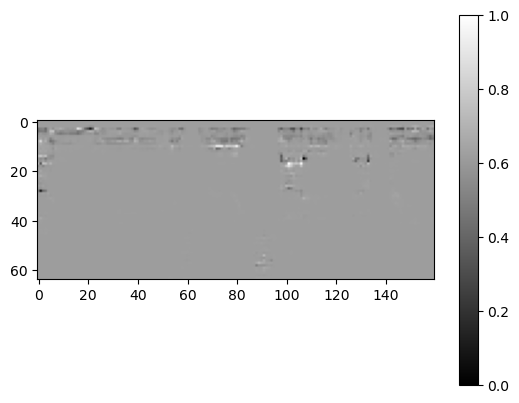

In [36]:
plt.figure()
plt.imshow(attributions_normalized[0].T,cmap='gray');
plt.colorbar();

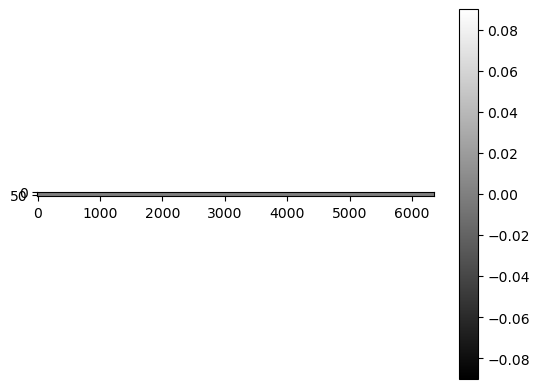

In [37]:
plt.figure()
plt.imshow(attributions[0].T, vmin=-0.09, vmax=0.09, cmap='gray');
plt.colorbar();

In [38]:
attr_mean = attributions.squeeze(0).max(dim=1).values.cpu().detach().numpy()

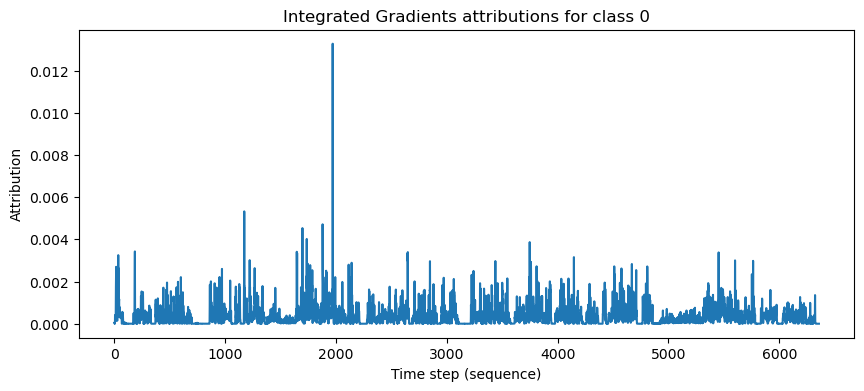

In [39]:
# Plot attributions over time
plt.figure(figsize=(10, 4))
plt.plot(attr_mean)
plt.title(f"Integrated Gradients attributions for class {target_class}")
plt.xlabel("Time step (sequence)")
plt.ylabel("Attribution")
plt.show()

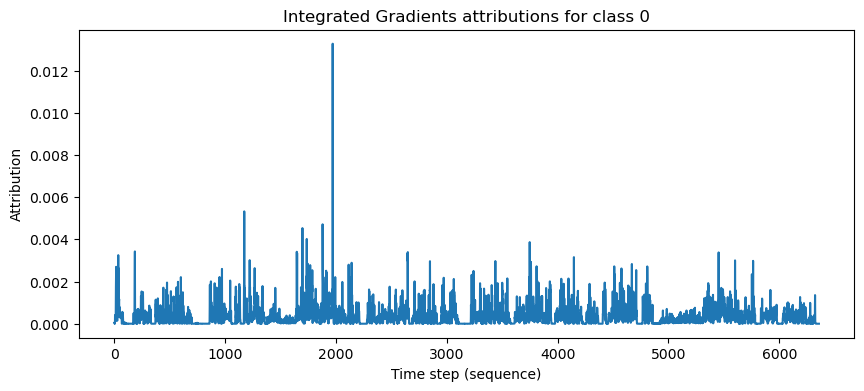

In [40]:
# Plot attributions over time
plt.figure(figsize=(10, 4))
plt.plot(attr_mean)
plt.title(f"Integrated Gradients attributions for class {target_class}")
plt.xlabel("Time step (sequence)")
plt.ylabel("Attribution")
plt.show()

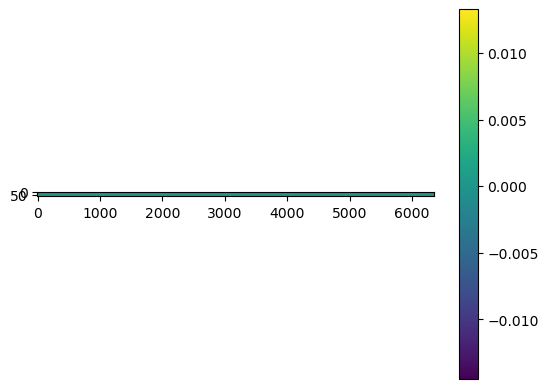

In [41]:
plt.figure()
plt.imshow(attributions[0].T);
plt.colorbar();

# ignore

In [42]:
target_class=0

/Users/Ashish.Jha/anaconda3/lib/python3.11/site-packages/captum/_utils/gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(


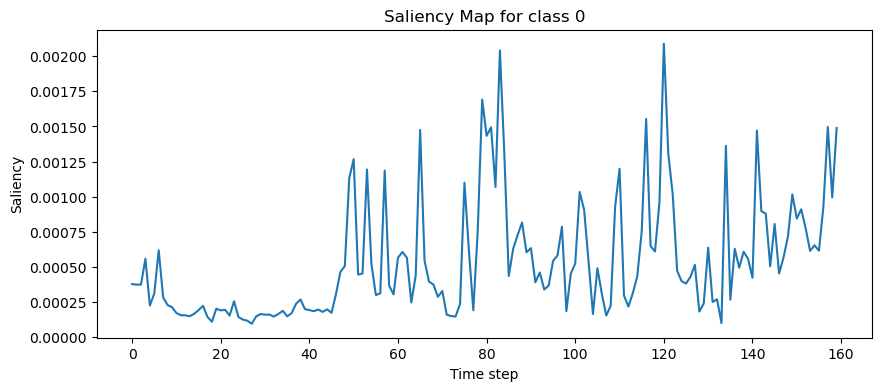

In [43]:
from captum.attr import Saliency

# Initialize the Saliency interpreter
saliency = Saliency(model)

# Compute saliency maps
saliency_maps = saliency.attribute(input_tensor[:,6080:6240,:], target=target_class)

# Visualize saliency maps
# Average saliency over mel-frequency bins
saliency_mean = saliency_maps.squeeze(0).mean(dim=1).cpu().detach().numpy()

# Plot saliency over time
plt.figure(figsize=(10, 4))
plt.plot(saliency_mean)
plt.title(f"Saliency Map for class {target_class}")
plt.xlabel("Time step")
plt.ylabel("Saliency")
plt.show()

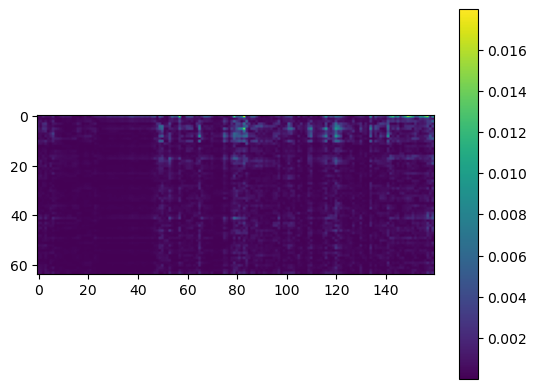

In [44]:
plt.figure()
plt.imshow(saliency_maps[0].T);
plt.colorbar();

In [45]:
target_class=1

/Users/Ashish.Jha/anaconda3/lib/python3.11/site-packages/captum/attr/_core/deep_lift.py:302: UserWarning: Setting forward, backward hooks and attributes on non-linear
               activations. The hooks and attributes will be removed
            after the attribution is finished
  warnings.warn(


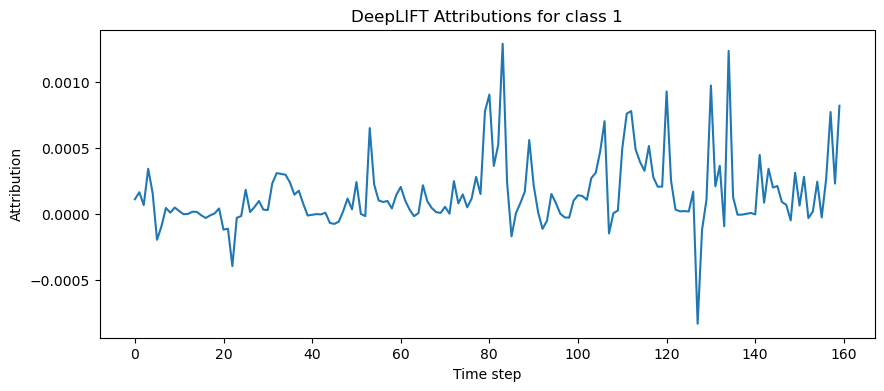

In [46]:
from captum.attr import DeepLift

# Initialize DeepLIFT interpreter
deeplift = DeepLift(model)

# Compute attributions
attributions_dl = deeplift.attribute(input_tensor[:,6080:6240,:], target=target_class)

# Visualize attributions
attr_dl_mean = attributions_dl.squeeze(0).mean(dim=1).cpu().detach().numpy()

plt.figure(figsize=(10, 4))
plt.plot(attr_dl_mean)
plt.title(f"DeepLIFT Attributions for class {target_class}")
plt.xlabel("Time step")
plt.ylabel("Attribution")
plt.show()

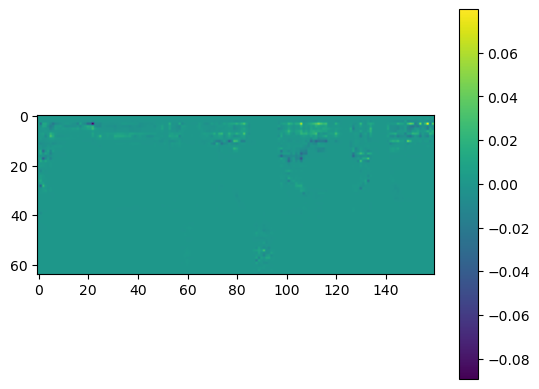

In [47]:
plt.figure()
plt.imshow(attributions_dl.cpu().detach().numpy()[0].T);
plt.colorbar();

In [48]:
sample_input = input_tensor[:,6080:6240,:]

In [49]:
target_class = 0

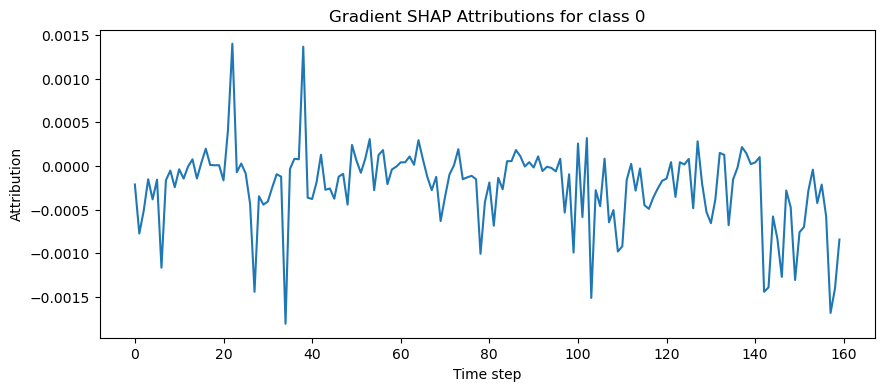

In [50]:
from captum.attr import GradientShap

# Initialize Gradient SHAP interpreter
gradient_shap = GradientShap(model)

# Define baseline distribution (e.g., random noise)
baseline_dist = torch.randn(5, *sample_input.shape[1:]).to(sample_input.device)

# Compute attributions
attributions_gs = gradient_shap.attribute(
    sample_input,
    baselines=baseline_dist,
    target=target_class
)

# Visualize attributions
attr_gs_mean = attributions_gs.squeeze(0).mean(dim=1).cpu().detach().numpy()

plt.figure(figsize=(10, 4))
plt.plot(attr_gs_mean)
plt.title(f"Gradient SHAP Attributions for class {target_class}")
plt.xlabel("Time step")
plt.ylabel("Attribution")
plt.show()

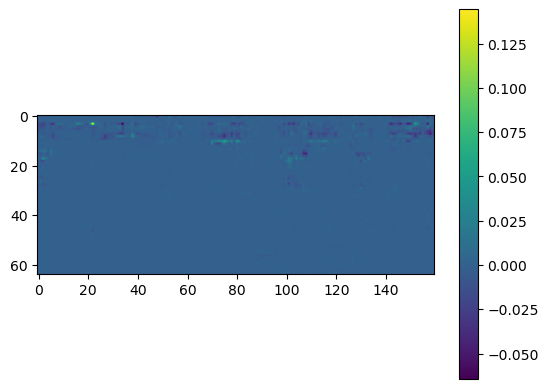

In [51]:
plt.figure()
plt.imshow(attributions_gs.cpu().detach().numpy()[0].T);
plt.colorbar();

In [52]:
target_class = 0

In [53]:
from captum.attr import Occlusion

# Initialize Occlusion interpreter
occlusion = Occlusion(model)

# Define sliding window parameters
sliding_window_shapes = (1, 10, sample_input.size(2))  # Occlude 10 time steps at a time

# Compute attributions
attributions_occ = occlusion.attribute(
    sample_input,
    strides=(1, 5, sample_input.size(2)),  # Stride of 5 time steps
    sliding_window_shapes=sliding_window_shapes,
    target=target_class
)

# Visualize attributions
attr_occ_mean = attributions_occ.squeeze(0).mean(dim=1).cpu().detach().numpy()

plt.figure(figsize=(10, 4))
plt.plot(attr_occ_mean)
plt.title(f"Occlusion Attributions for class {target_class}")
plt.xlabel("Time step")
plt.ylabel("Attribution")
plt.show()

AssertionError: Stride for input index 0 is (1, 5, 64), which is invalid for input with shape torch.Size([1, 160, 64]). It must be either an int or a tuple with length equal to len(input_shape) - 1.

In [ ]:
target_class = 0

In [ ]:
from captum.attr import FeatureAblation

# Initialize Feature Ablation interpreter
ablation = FeatureAblation(model)

# Compute attributions
attributions_ablation = ablation.attribute(sample_input, target=target_class)

# Visualize attributions
attr_ablation_mean = attributions_ablation.squeeze(0).mean(dim=1).cpu().detach().numpy()

plt.figure(figsize=(10, 4))
plt.plot(attr_ablation_mean)
plt.title(f"Feature Ablation Attributions for class {target_class}")
plt.xlabel("Time step")
plt.ylabel("Attribution")
plt.show()

In [ ]:
plt.figure()
plt.imshow(attributions_gs.cpu().detach().numpy()[0].T);
plt.colorbar();

In [ ]:
target_class = 0

In [ ]:
from captum.attr import GuidedBackprop

# Initialize Guided Backpropagation interpreter
guided_bp = GuidedBackprop(model)

# Compute attributions
attributions_gb = guided_bp.attribute(sample_input, target=target_class)

# Visualize attributions
attr_gb_mean = attributions_gb.squeeze(0).mean(dim=1).cpu().detach().numpy()

plt.figure(figsize=(10, 4))
plt.plot(attr_gb_mean)
plt.title(f"Guided Backpropagation Attributions for class {target_class}")
plt.xlabel("Time step")
plt.ylabel("Attribution")
plt.show()

In [ ]:
plt.figure()
plt.imshow(attributions_gs.cpu().detach().numpy()[0].T);
plt.colorbar();

In [ ]:
target_class=0

In [ ]:
from captum.attr import Deconvolution

# Initialize Deconvolution interpreter
deconv = Deconvolution(model)

# Compute attributions
attributions_deconv = deconv.attribute(sample_input, target=target_class)

# Visualize attributions
attr_deconv_mean = attributions_deconv.squeeze(0).mean(dim=1).cpu().detach().numpy()

plt.figure(figsize=(10, 4))
plt.plot(attr_deconv_mean)
plt.title(f"Deconvolution Attributions for class {target_class}")
plt.xlabel("Time step")
plt.ylabel("Attribution")
plt.show()


In [ ]:
plt.figure()
plt.imshow(attributions_deconv.cpu().detach().numpy()[0].T);
plt.colorbar();

In [ ]:
plt.figure()
plt.imshow(attributions_deconv.cpu().detach().numpy()[0].T);
plt.colorbar();

In [ ]:
captum.__version__